# Time Series Modeling Final Project

## Imports

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)
from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from random import gauss as gs

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA

import itertools
#from pmdarima import auto_arima

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib inline

/Users/nicholastjandra/anaconda3/envs/learn-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Reading in data

In [2]:
# train df
train_subject_df = pd.read_csv("../UCI_HAR_Dataset/train/subject_train.txt", sep=' ', header=None)
x_train_df = pd.read_fwf("../UCI_HAR_Dataset/train/X_train.txt", header=None)
y_train_df = pd.read_csv("../UCI_HAR_Dataset/train/y_train.txt", sep=' ', header=None)

# test df
test_subject_df = pd.read_csv("../UCI_HAR_Dataset/test/subject_test.txt", sep=' ', header=None)
x_test_df = pd.read_fwf("../UCI_HAR_Dataset/test/X_test.txt", header=None)
y_test_df = pd.read_csv("../UCI_HAR_Dataset/test/y_test.txt", sep=' ', header=None)

In [3]:
x_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [4]:
train_subject_df.head

<bound method NDFrame.head of        0
0      1
1      1
2      1
3      1
4      1
...   ..
7347  30
7348  30
7349  30
7350  30
7351  30

[7352 rows x 1 columns]>

In [5]:
y_train_df.head()

,0
0,5
1,5
2,5
3,5
4,5


In [6]:
train_subject_df.value_counts()

25    409
21    408
26    392
30    383
28    382
27    376
23    372
17    368
16    366
19    360
1     347
29    344
3     341
15    328
6     325
14    323
22    321
11    316
7     308
5     302
8     281
Name: count, dtype: int64

## Data Preparation

In [7]:
x_train_df.insert(0, 'Position', y_train_df)
x_train_df.insert(0, 'Train Subject', train_subject_df)
train_df = x_train_df

In [8]:
train_df.head() # much better!

,Train Subject,Position,0,1,2,3,4,5,6,7,...,551,552,553,554,555,556,557,558,559,560
0,1,5,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,1,5,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,1,5,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,1,5,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,1,5,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [9]:
train_df_25 = train_df[(train_df['Train Subject']==25)]
train_df_25.reset_index(drop=True,inplace=True)
train_df_25.head()

# We filter for only one subject to ensure temporal consistency across rows
# The original dataframe consisted of multiple subjects across different times
# Subject 25 also happens to have the most data from the previous value counts we did

,Train Subject,Position,0,1,2,3,4,5,6,7,...,551,552,553,554,555,556,557,558,559,560
0,25,5,0.304858,-0.020152,-0.106627,-0.963456,-0.941173,-0.962273,-0.974110,-0.942358,...,0.113785,0.310516,-0.064405,-0.849814,-0.195862,-0.636567,0.533676,-0.664223,0.197731,-0.199569
1,25,5,0.288476,-0.018694,-0.116258,-0.988980,-0.956936,-0.989668,-0.990321,-0.953451,...,0.127836,-0.459029,-0.826325,-0.268170,0.842660,0.124883,0.739872,-0.664843,0.198687,-0.198571
2,25,5,0.274164,-0.016013,-0.112990,-0.994482,-0.971343,-0.984095,-0.994842,-0.970196,...,0.278337,-0.557628,-0.843209,0.474315,-0.056273,0.394090,0.552374,-0.667613,0.199366,-0.196007
3,25,5,0.276513,-0.015279,-0.103881,-0.995081,-0.977921,-0.989834,-0.995457,-0.977896,...,0.345901,-0.812628,-0.964717,-0.019486,-0.333749,0.674358,-0.378258,-0.668897,0.199224,-0.195063
4,25,5,0.277716,-0.016574,-0.101086,-0.996522,-0.987364,-0.989922,-0.997018,-0.987555,...,0.262911,-0.489030,-0.800831,-0.176694,-0.180397,0.800931,-0.321091,-0.667391,0.198446,-0.196680


In [10]:
train_df_25['Position'].value_counts()

Position
5    74
1    74
6    73
4    65
2    65
3    58
Name: count, dtype: int64

In [11]:
pca = PCA(n_components=1) 
tBodyAcc_mean_XYZ = pca.fit_transform(train_df_25[[0,1,2]])
tBodyAcc_mean_XYZ = pd.Series(tBodyAcc_mean_XYZ.flatten())
# Here we are reducing the data from the first three features 
# (tBodyAcc-mean()-X, tBodyAcc-mean()-Y, tBodyAcc-mean()-Z) to one principal component
# We will use this as what we want to model

In [12]:
train_df_25.insert(2, 'Body Acc XYZ', tBodyAcc_mean_XYZ)
train_df_25 = train_df_25[['Position','Body Acc XYZ']]
train_df_25.head()

,Position,Body Acc XYZ
0,5,-0.013136
1,5,-0.011977
2,5,-0.003320
3,5,0.001567
4,5,0.003515


## Visualizing Data

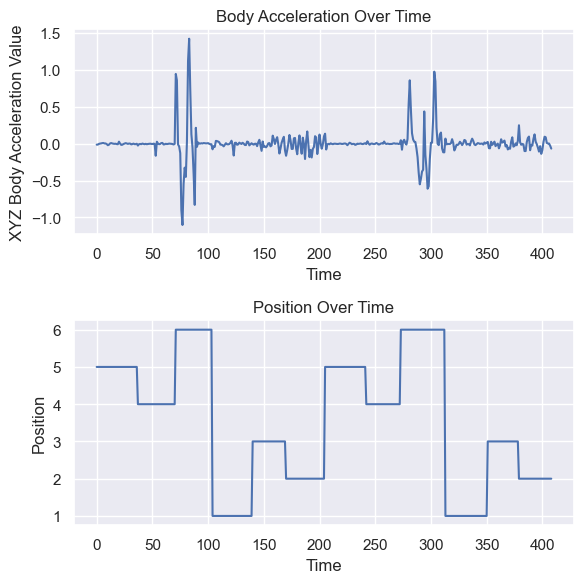

In [13]:
fig, ax = plt.subplots(figsize = (6,6),nrows=2)
ax[0].plot(train_df_25['Body Acc XYZ'])
ax[0].set_title('Body Acceleration Over Time')
ax[0].set_ylabel('XYZ Body Acceleration Value')
ax[0].set_xlabel('Time')
ax[1].plot(train_df_25['Position'])
ax[1].set_title('Position Over Time')
ax[1].set_ylabel('Position')
ax[1].set_xlabel('Time')
plt.tight_layout();

# We visualize both values because we will try to model both over time
# However we first need to make the data stationary
# As you can see below, it does not look stationary at all

## Stationarizing Data

This is a crucial time series modeling step when our data looks like it is temporally dependent (i.e. the value at t = 1 looks drastically different than t = 2.

We stationarize by simply differencing over time intervals (lags). We will do it manually below just to visualize what our stationarized data will look like, but when modeling with sklearn, we can simply tweak a parameter in the function to do so.

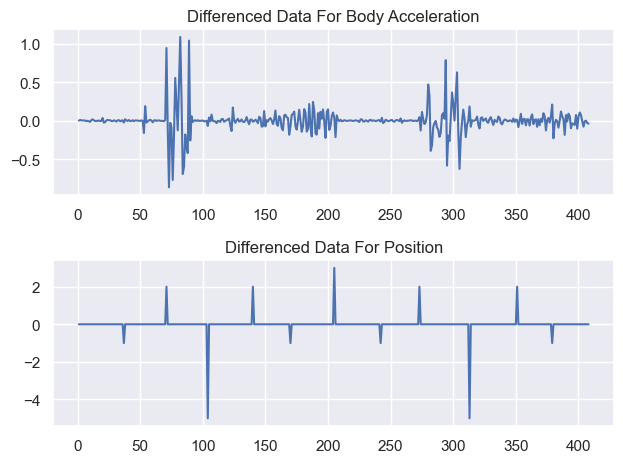

In [14]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(train_df_25['Body Acc XYZ'].diff(1))
ax[0].set_title('Differenced Data For Body Acceleration')
ax[1].plot(train_df_25['Position'].diff(1))
ax[1].set_title('Differenced Data For Position')
plt.tight_layout();

In [15]:
dftest = adfuller(train_df_25['Body Acc XYZ'].diff().dropna())
print ('Results of Dickey-Fuller Test for Body Acceleration:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test for Body Acceleration:
Test Statistic                -9.026810e+00
p-value                        5.581526e-15
#Lags Used                     1.500000e+01
Number of Observations Used    3.920000e+02
Critical Value (1%)           -3.447142e+00
Critical Value (5%)           -2.868941e+00
Critical Value (10%)          -2.570713e+00
dtype: float64


In [16]:
dftest = adfuller(train_df_25['Position'].diff().dropna())
print ('Results of Dickey-Fuller Test for Position:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test for Position:
Test Statistic                 -20.130247
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    407.000000
Critical Value (1%)             -3.446520
Critical Value (5%)             -2.868668
Critical Value (10%)            -2.570567
dtype: float64


Although our data might not look different, but we can see the y-range has reduced significantly, indicating less temporal dependence. There is now more uniformity across time. 

After running the Dickey-Fuller test, we can see our p-values indicate our data can be used for modeling as well.

## Plotting ACF And PACF To Determine Parameter Values

Plotting the ACF will help us determine the moving average (MA) parameter while plotting PACF will help us determine the autoregressive (AR) parameter.

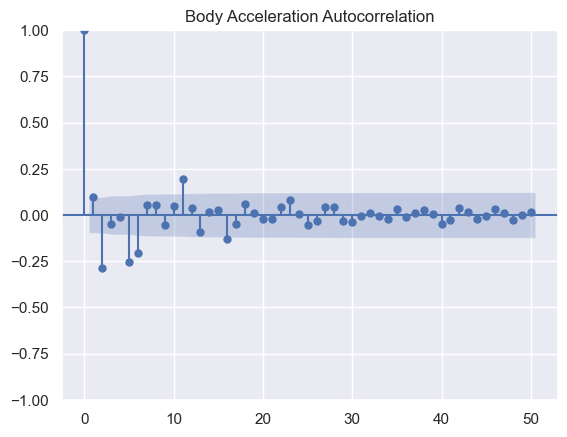

In [17]:
plot_acf(train_df_25['Body Acc XYZ'].diff().dropna(), lags=50, title = 'Body Acceleration Autocorrelation');

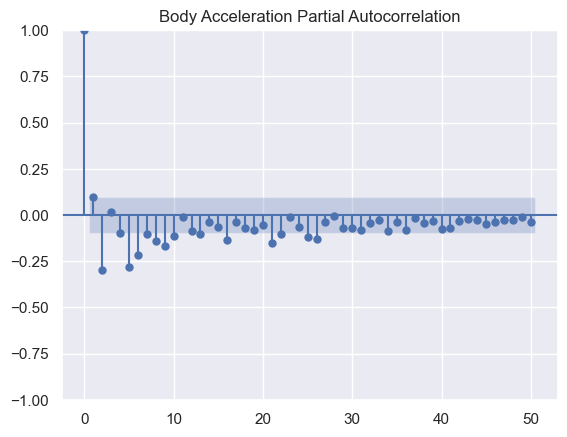

In [18]:
plot_pacf(train_df_25['Body Acc XYZ'].diff().dropna(), method='ywm', 
          lags=50, title = 'Body Acceleration Partial Autocorrelation');

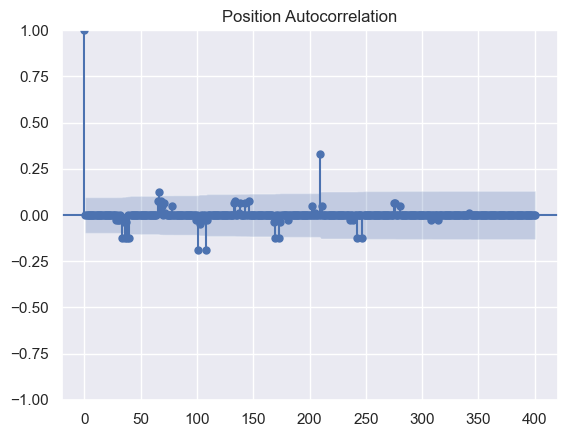

In [19]:
plot_acf(train_df_25['Position'].diff().dropna(), lags=400, title = 'Position Autocorrelation');
# It appears there is seasonality for position

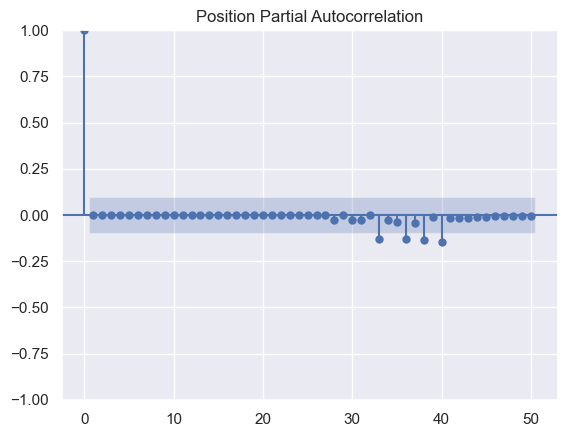

In [20]:
plot_pacf(train_df_25['Position'].diff().dropna(), method='ywm', 
          lags=50, title = 'Position Partial Autocorrelation');

From these plots, it appears we should set both our MA and AR parameter as 1 for position and body acceleration.

## Train Test Split

In [21]:
cutoff = round(train_df_25.shape[0]*.75)
cutoff

307

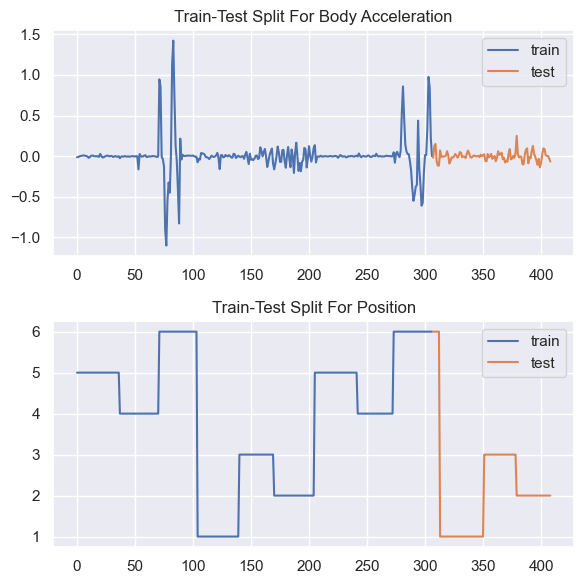

In [22]:
train = train_df_25[:cutoff]

test = train_df_25[cutoff:]

fig, ax = plt.subplots(figsize = (6,6),nrows=2)
ax[0].plot(train['Body Acc XYZ'], label='train')
ax[0].plot(test['Body Acc XYZ'], label='test')
ax[0].set_title('Train-Test Split For Body Acceleration');
ax[0].legend();

ax[1].plot(train['Position'], label='train')
ax[1].plot(test['Position'], label='test')
ax[1].set_title('Train-Test Split For Position');
ax[1].legend();
plt.tight_layout();

## Modeling

We will use both ARIMA and SARIMAX for position and body acceleration then compare because of some observed seasonality earlier.

#### Body Acceleration ARIMA Model

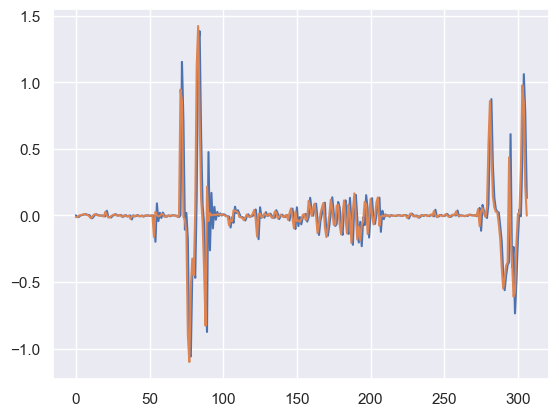

In [23]:
acc_arima_model = ARIMA(train['Body Acc XYZ'], order=(1, 1, 1)).fit()
y_hat_train = acc_arima_model.predict(typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_train)
ax.plot(train['Body Acc XYZ']);

In [24]:
acc_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Body Acc XYZ   No. Observations:                  307
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  91.676
Date:                Thu, 30 Nov 2023   AIC                           -177.351
Time:                        16:47:55   BIC                           -166.181
Sample:                             0   HQIC                          -172.884
                                - 307                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4111      0.127     -3.235      0.001      -0.660      -0.162
ma.L1          0.6317      0.118      5.375      0.000       0.401       0.862
sigma2         0.0321      0.001     32.559      0.000       0.030       0.034
===================================================================================
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):              2341.63
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Position ARIMA Model

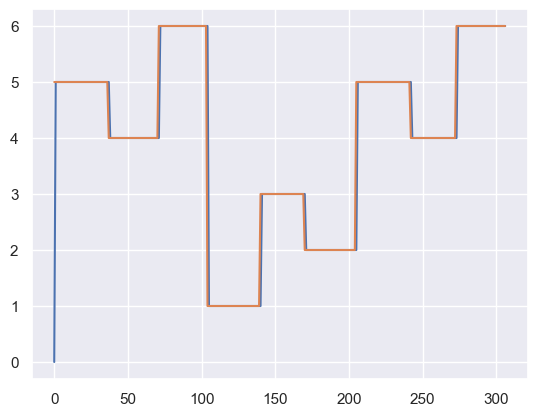

In [25]:
position_arima_model = ARIMA(train['Position'], order=(1, 1, 1)).fit()
y_hat_train = position_arima_model.predict(typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_train)
ax.plot(train['Position']);

In [26]:
position_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Position   No. Observations:                  307
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -153.935
Date:                Thu, 30 Nov 2023   AIC                            313.870
Time:                        16:47:55   BIC                            325.041
Sample:                             0   HQIC                           318.338
                                - 307                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       1.203e-06   1.21e-17   9.95e+10      0.000     1.2e-06     1.2e-06
ma.L1      -1.203e-06   1.21e-17  -9.95e+10      0.000    -1.2e-06    -1.2e-06
sigma2         0.1601      0.002     85.466      0.000       0.156       0.164
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            112543.76
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.80   Skew:                            -3.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        96.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.95e+46. Standard errors may be unstable.
"""

#### Body Acceleration SARIMAX Model

In [27]:
acc_sari_mod = SARIMAX(train['Body Acc XYZ'],
                   order=(1, 1, 1),
                   seasonal_order=(0, 1, 1, 150),
                   enforce_stationarity=False,
                   enforce_invertibility=False).fit()

/Users/nicholastjandra/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=  1.17018D-02    |proj g|=  8.28109D-02

At iterate    5    f=  2.71218D-03    |proj g|=  3.97786D-02

At iterate   10    f=  1.36436D-03    |proj g|=  4.25346D-03

At iterate   15    f=  1.26718D-03    |proj g|=  2.32248D-04

At iterate   20    f=  1.20071D-03    |proj g|=  1.81416D-03

At iterate   25    f=  1.18678D-03    |proj g|=  6.32464D-04

At iterate   30    f=  1.18505D-03    |proj g|=  1.57426D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     46      1     0     0   1.949D-05   1.185D-03
  F =   1.1850213949935592E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

#### Position SARIMAX Model

In [30]:
position_sari_mod = SARIMAX(train['Position'],
                   order=(1, 1, 1),
                   seasonal_order=(0, 1, 1, 150),
                   enforce_stationarity=False,
                   enforce_invertibility=False).fit()

/Users/nicholastjandra/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.59816D-03    |proj g|=  2.29481D-02


 This problem is unconstrained.


  ys=-5.447E-02  -gs= 1.230E-02 BFGS update SKIPPED
  ys=-3.405E-03  -gs= 8.734E-02 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f= -1.39544D-01    |proj g|=  1.39544D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5     50      1     2     0   1.395D+04  -1.395D-01
  F = -0.13954355962724868     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


## Predictions on Test Set

#### Body Acceleration ARIMA Prediction

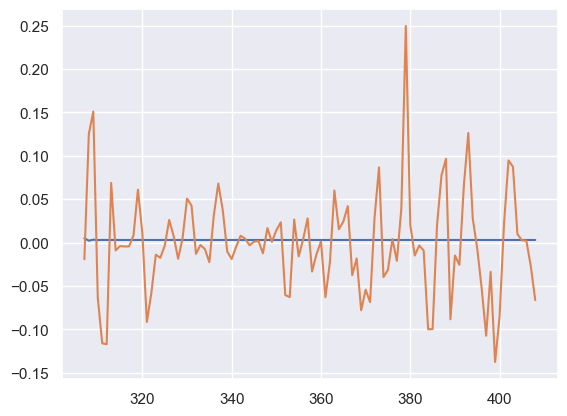

In [35]:
y_hat_test = acc_arima_model.predict(start=test['Body Acc XYZ'].index[0], end=test['Body Acc XYZ'].index[-1])

fig, ax = plt.subplots()
ax.plot(y_hat_test);
ax.plot(test['Body Acc XYZ']);

#### Position ARIMA Prediction

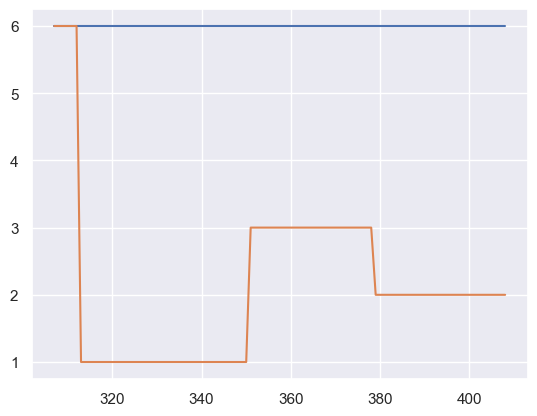

In [36]:
y_hat_test = position_arima_model.predict(start=test['Position'].index[0], end=test['Position'].index[-1])

fig, ax = plt.subplots()
ax.plot(y_hat_test);
ax.plot(test['Position']);

#### Body Acceleration SARIMAX Prediction

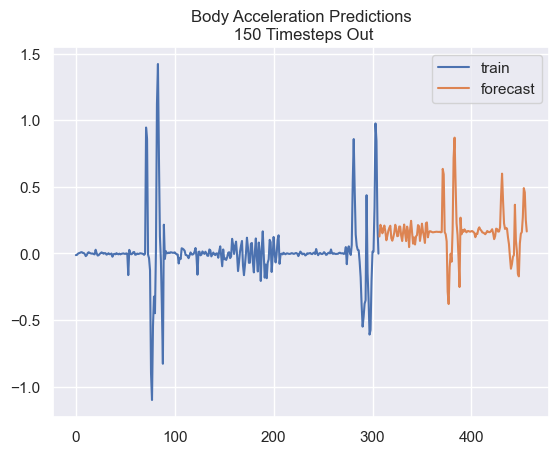

In [39]:
fig, ax = plt.subplots()
ax.plot(train['Body Acc XYZ'], label='train')
#ax.plot(test['Body Acc XYZ'], label='test')
ax.plot(acc_forecast, label='forecast')
ax.set_title('Body Acceleration Predictions\n 150 Timesteps Out')

plt.legend();

In [28]:
acc_forecast = acc_sari_mod.forecast(steps=150)

#### Position SARIMAX Prediction

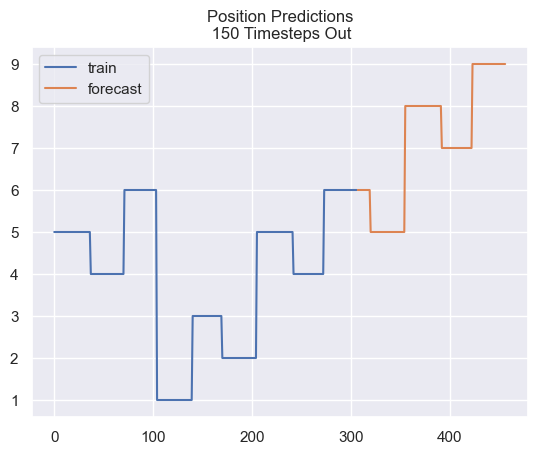

In [40]:
fig, ax = plt.subplots()
ax.plot(train['Position'], label='train')
#ax.plot(test['Position'], label='test')
ax.plot(position_forecast, label='forecast')

ax.set_title('Position Predictions\n 150 Timesteps Out')

plt.legend();

In [31]:
position_forecast = position_sari_mod.forecast(steps=150)

## Conclusions